# Flood Test for Bangladesh Bounding Box (88, 20, 93, 27)
In order to evaluate coastal vulnurability caused by Sea level rise, flood Maps for the study area are produced. To produce flood maps in this steps 3 main input dataset are considered: Sea level Rise for the years of 2020-2100, Mean Sea Level, and Digital Elevation Model. The Sea Level Change data for the two Climate Change scenarios: SSP119 and SSP585 and two epochs of the years 2020 and 2100 is extracted from the projected Sea Level Change of IPCC AR6 , the median data freezed. For this flood test, only altimetry data are considered and Tide Guage data are ommited from the main data set. Then interpolation for the two time epochs 2020 and 2100 is applied. In this flood test the case study of Bangladesh Bounding box is considered. So the raster files of interpolated IPCC sea level change dataset is masked with Bangladesh bounding box. Then Mean sea level and Bedrock Elevation for the study area are downloaded from the Earth Topography Global Relief Model (ETOPO 2022) National Center for Environmental Information (NCEI) of NOAA. The rest of the proces has been performed in QGIS software. The Mosaic rasters that include the bounding of the case study area obtained from NCEI. They are merged and clipped for the bbox. The Digital Elevation Model is computed using Mean sea Level and Bedrock elevatiion. Afterwards, Sea level for the years 2020 and 2100 for the two intended scenarios are calculated. Having the DEM and Sea level for each year, the flooded area is computed.

In [3]:
#necessary packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.interpolate import griddata
import rasterio
from rasterio.plot import show
import cartopy.crs as ccrs
from rasterio.transform import from_origin
import fiona
import rasterio.mask
import geopandas as gpd
from osgeo import gdal
from rasterio.mask import mask
import cartopy.feature as cfeature
import matplotlib.colors as colors
#import matplotlib.patches as mpatches

In [37]:
#%matplotlib widget

# IPCC Sea Level Change projection Dataset

The dataset is IPCC AR6 Regional sea level change medium confidence projection 
https://zenodo.org/record/5914710

In [4]:
#open the data for the two scenarios: SSP119 and SSP585
file_path_ssp119 = '/home/sahar/Data/IPCC/ar6-regional-confidence/regional/confidence_output_files/medium_confidence/ssp119/total_ssp119_medium_confidence_values.nc'
file_path_ssp585 = '/home/sahar/Data/IPCC/ar6-regional-confidence/regional/confidence_output_files/medium_confidence/ssp585/total_ssp585_medium_confidence_values.nc'
#open netcdf files
ds_ssp119 = xr.open_dataset(file_path_ssp119)
ds_ssp585 = xr.open_dataset(file_path_ssp585)

dataset for SSP119:

In [3]:
ds_ssp119

<xarray.Dataset>
Dimensions:           (locations: 66190, quantiles: 107, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
  * quantiles         (quantiles) float64 0.0 0.001 0.005 ... 0.995 0.999 1.0
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (quantiles, years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:47:32 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...

Dataset for scenario SSP585

In [55]:
ds_ssp119

<xarray.Dataset>
Dimensions:           (locations: 66190, quantiles: 107, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
  * quantiles         (quantiles) float64 0.0 0.001 0.005 ... 0.995 0.999 1.0
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (quantiles, years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:47:32 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...

The dataset has geographical coordinate system with 10-year temporal resolution and temporal coverage from 2020 to 2150. Geographical resolution altimetry dataset is 1 Degree East longitude  1 Degree North latitude.

# Data Preprocessing
50% probability of the data which represents the median will be considered to narrow down the complexity of uncertainity of the dataset.

In [5]:
#select the median (50% probability)
ds_median_ssp119 = ds_ssp119.sel(quantiles=0.50, method='nearest')
ds_median_ssp119 = ds_median_ssp119.drop_vars('quantiles')
ds_median_ssp585 = ds_ssp585.sel(quantiles=0.50, method='nearest')
ds_median_ssp585 = ds_median_ssp585.drop_vars('quantiles')
print(f'dataset for the scenario ssp119 {ds_median_ssp119}')
print('***************************************')
print(f'dataset for the scenario ssp585 {ds_median_ssp585}')

dataset for the scenario ssp119 <xarray.Dataset>
Dimensions:           (locations: 66190, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:47:32 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...
***************************************
dataset for the scenario ssp585 <xarray.Dataset>
Dimensions:           (locations: 66190, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
Data variables:
    lat               (loc

in this step we focus on altimetry data so only grid data with integer latitude and longitude will be considered.

In [6]:
#extract grid (altimetry data)
ds_median_ssp119 = ds_median_ssp119.sel(locations=(ds_median_ssp119.lat % 1 == 0) & (ds_median_ssp119.lon % 1 == 0))
ds_median_ssp585 = ds_median_ssp585.sel(locations=(ds_median_ssp585.lat % 1 == 0) & (ds_median_ssp585.lon % 1 == 0))

# Interpolation of grid Sea Level Change
The Interpolation for the years 2020 and 2100 of the scenario SSP119 and SSP585 has been done for both altimetry and grid data with 0.1 degree resolution. The process has been performed by with Scipy-interpolation library and the results- which are 4 maps- are saved as Geotiff with rasterio package with the coordinate refernce of original data which is 4326 (WGS48) and plotted with Cartopy package.

In [9]:
#creating list of datasets
dataset_names = ['ds_median_ssp119', 'ds_median_ssp585']
# Specify the directory for saving the GeoTIFF outputs
output_directory = '/home/sahar/output_tif/'
#loop over the datasets to do the interpolation for the year 2020 and 2100 for ssp119 and ssp585


n= 20 #range of colors
cmap = cm.get_cmap('cool', n-1) #create cmap of n-1 ranges
cranges = np.linspace(-3, 3, n) #(put n ranges btw min SLC and max SLC)
norms = colors.BoundaryNorm(cranges, cmap.N)


for dataset_name in dataset_names:
    #getting the dataaset
    dataset = globals()[dataset_name]
    
    #extract sea level change for 2020
    sea_level_2020 = dataset['sea_level_change'].sel(years=2020)
    
    #extract sea level change for 2100
    sea_level_2100 = dataset['sea_level_change'].sel(years=2100)
    
    #inputs of the interpolation for 2020
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    sea_level_values_2020 = sea_level_2020.values.flatten() / 1000  # Convert mm to m
    
    #inputs of the interpolation for 2100
    sea_level_values_2100 = sea_level_2100.values.flatten() / 1000  # Convert mm to m

    #create a lat-lon grid with 0.5-degree resolution
    lat_grid = np.arange(np.max(lat), np.min(lat) - 0.5, -0.5)
    lon_grid = np.arange(np.min(lon), np.max(lon) + 0.5, 0.5)
    #generate grid
    xi_lon_grid, xi_lat_grid = np.meshgrid(lon_grid, np.flip(lat_grid))
    xi_points = np.column_stack((xi_lat_grid.ravel(), xi_lon_grid.ravel()))  # To put grid-lat, grid_lon_1d in one 2d array
    points = np.column_stack((lat, lon))  # To put original lat lon in one 2d array

    
    #pertrform interpolation of SLC on xi_points based on nearest neighbor method for 2020
    interpolated_sea_level_change_nearest_2020 = griddata(points, sea_level_values_2020, xi_points, method='nearest')

    #pertrform interpolation of SLC on xi_points based on nearest neighbor method for 2100
    interpolated_sea_level_change_nearest_2100 = griddata(points, sea_level_values_2100, xi_points, method='nearest')

    #reshape the interpolated arrays to match the grid shape
    interpolated_sea_level_change_nearest_2020 = np.reshape(interpolated_sea_level_change_nearest_2020, xi_lon_grid.shape)
    interpolated_sea_level_change_nearest_2100 = np.reshape(interpolated_sea_level_change_nearest_2100, xi_lon_grid.shape)
    
    output_filename_2020 = f'sea_level_change_map_nearest2020_{dataset_name}.tif'
    height, width = interpolated_sea_level_change_nearest_2020.shape #get the dimensions of the interpolated sea level change array
    # define the affine transformation matrix for the geotiff
    # the origin is set to the minimum longitude and maximum latitude
    #thepixel size is set to the resolution of the latitude and longitude arrays
    transform = from_origin(np.min(lon_grid), np.min(lat_grid), lon_grid[1] - lon_grid[0], lat_grid[1] - lat_grid[0])
    
    #save the figure as a GeoTIFF for 2020
    output_filename_2020 = os.path.join(output_directory, f'sea_level_change_alt_2020_{dataset_name}.tif')
    with rasterio.open(output_filename_2020, 'w', driver='GTiff', height=height, width=width, count=1, dtype=interpolated_sea_level_change_nearest_2020.dtype, crs='EPSG:4326', transform=transform) as dst:
        dst.write(interpolated_sea_level_change_nearest_2020, 1)
    print(f"{output_filename_2020} is saved.")


    output_filename_2100 = f'sea_level_change_map_nearest2100_{dataset_name}.tif'
    height, width = interpolated_sea_level_change_nearest_2100.shape #get the dimensions of the interpolated sea level change array
    # define the affine transformation matrix for the geotiff
    # the origin is set to the minimum longitude and maximum latitude
    #thepixel size is set to the resolution of the latitude and longitude arrays
    transform = from_origin(np.min(lon_grid), np.min(lat_grid), lon_grid[1] - lon_grid[0], lat_grid[1] - lat_grid[0])
    # Save the figure as a GeoTIFF for 2100
    output_filename_2100 = os.path.join(output_directory, f'sea_level_change_alt_2100_{dataset_name}.tif')
    with rasterio.open(output_filename_2100, 'w', driver='GTiff', height=height, width=width, count=1, dtype=interpolated_sea_level_change_nearest_2100.dtype, crs='EPSG:4326', transform=transform) as dst:
        dst.write(interpolated_sea_level_change_nearest_2100, 1)
    print(f"{output_filename_2100} is saved.")

     #flip the interpolated arrays vertically
    interpolated_sea_level_change_nearest_2020 = np.flipud(interpolated_sea_level_change_nearest_2020)
    interpolated_sea_level_change_nearest_2100 = np.flipud(interpolated_sea_level_change_nearest_2100)
    
    #plot the interpolation for 2020
    plt.figure(figsize=(11, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    im = ax.imshow(interpolated_sea_level_change_nearest_2020, extent=[np.min(lon_grid), np.max(lon_grid), np.min(lat_grid), np.max(lat_grid)], cmap='jet')
    
    plt.colorbar(im, label='Sea Level Change (m)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Interpolated Sea Level Change Map 2020 based on Altimetry Data- {dataset_name}')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    
    #plot the interpolation for 2100
    plt.figure(figsize=(11, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = ax.imshow(interpolated_sea_level_change_nearest_2100, extent=[np.min(lon_grid), np.max(lon_grid), np.min(lat_grid), np.max(lat_grid)], cmap='jet')

    plt.colorbar(im, label='Sea Level Change (m)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Interpolated Sea Level Change Map 2100 based on Altimetry Data - {dataset_name}')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False





/tmp/ipykernel_9644/2163032129.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool', n-1) #create cmap of n-1 ranges


ValueError: zero-size array to reduction operation minimum which has no identity

# Masking Bangladesh boundin Box
The bounding box of the case study, here Bangladesh is created as shapefile with geopandas and Shapely  packages

In [2]:
from shapely.geometry import Polygon
#bounding box coordinate
bbox = (88, 20, 93, 27) #https://gist.github.com/graydon/11198540
#creating polygon using shapeöly
polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
#making a GeoDataFrame with the polygon
gdf = gpd.GeoDataFrame(geometry=[polygon])
#set the coordinate
gdf.crs = "EPSG:4326"

#dfine the output shapefile path
area_bbox = "/home/sahar/output_shp/Bangladesh_bbox.shp"

# Save the GeoDataFrame as a shapefile
gdf.to_file(area_bbox)
area_bbox= gpd.read_file(area_bbox)


Using rasterio library, the 4 the sea level change global maps have been masked with Vietnam bounding Box shapefile and the results are saved as Geotiff files with rasterio package and plotted with Cartopy package.

/tmp/ipykernel_8656/2632447919.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool', n-1) #create cmap of n-1 ranges


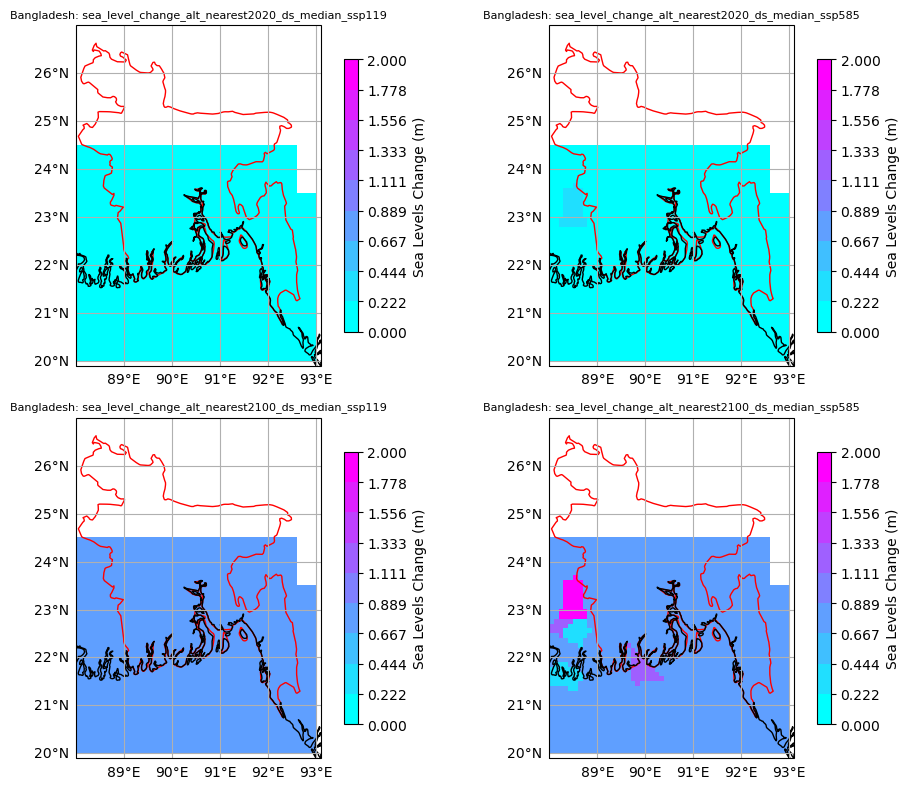

In [96]:
area_bbox = "/home/sahar/output_shp/Bangladesh_bbox.shp"
#define the output directory for saving the masked tif
output_directory = "/home/sahar/output_tif/"
# the shapefile of administrative boundries of the area is downloaded from : https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/?q=bangladesh
area_adm_path = "/home/sahar/Data/Bangladesh/Bangladesh-boundaries.shp" 
shapefile = gpd.read_file(area_adm_path)

#create geodataframe out of the shapefile of boundries
gdf = gpd.GeoDataFrame(geometry=shapefile["geometry"])
#list of interpolated sea level change of IPCC
IPCC_SLC = [
    "/home/sahar/output_tif/sea_level_change_alt_nearest2020_ds_median_ssp119.tif",
    "/home/sahar/output_tif/sea_level_change_alt_nearest2020_ds_median_ssp585.tif",
    "/home/sahar/output_tif/sea_level_change_alt_nearest2100_ds_median_ssp119.tif",
    "/home/sahar/output_tif/sea_level_change_alt_nearest2100_ds_median_ssp585.tif"
]

#read the shapefile and extract the shapes
with fiona.open(area_bbox, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

#set the figure size
fig = plt.figure(figsize=(10, 8))


#define the same legend for all maps in order to be comparable
n= 10 #range of colors
cmap = cm.get_cmap('cool', n-1) #create cmap of n-1 ranges
cranges = np.linspace(0, 2, n) #(put n ranges btw min SLC and max SLC)
norm = colors.BoundaryNorm(cranges, cmap.N)

#mask and plot for all subsets in a loop
for i, SLC in enumerate(IPCC_SLC):
    #extract the filename without the directory path& extension
    filename = os.path.splitext(os.path.basename(SLC))[0]

    # dfine the output path for the masked TIFF
    output_path = os.path.join(output_directory, f"Bangladesh_alt_{filename}.tif")

    #open the raster file
    with rasterio.open(SLC) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=src.nodata)
        out_meta = src.meta

        #replace the out of mask pixels with NoData value
        out_image = np.where(out_image == 0, src.nodata, out_image)

        #set the NoData value in the metadata
        out_meta["nodata"] = src.nodata

    #update the metadata for the masked TIFF
    out_meta.update(
        driver="GTiff",
        height=out_image.shape[1],
        width=out_image.shape[2],
        transform=out_transform
    )

    # write the masked TIFF to the output path
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)

    #open the masked TIFF file
    with rasterio.open(output_path) as src:
        # Read the image data
        image = src.read(1)
        # Get the transform and bounds of the image
        transform = src.transform
        bounds = src.bounds
        
         #flip vertically
    image = np.flipud(image)

    #create a Cartopy GeoAxes instance
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree())
    


    
    # aadd the image to the plot
    img = ax.imshow(image, extent=(bounds.left, bounds.right, bounds.top, bounds.bottom), origin='upper', cmap=cmap, norm= norm)

    #Add the area-adm to the plot
    ax.add_geometries(gdf["geometry"], crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")

    #add map features (e.g., coastlines) if desired
    ax.coastlines()

    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label('Sea Levels Change (m)')
    ax.set_title(f"Bangladesh: {filename}", fontsize = 8)

plt.tight_layout()
plt.show()


The red border is the administrative boundries of Bangladesh

In [78]:
cranges

array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ])

# Geoid, Mean Sea Level and Digital Elevation Model
**The geoid is a model of global mean sea level that is used to measure precise surface elevations.**

The radius at the equator is larger than at the poles due to the long-term effects of the earth's rotation. And, at a smaller scale, there is topography—mountains have more mass than a valley and thus the pull of gravity is regionally stronger near mountains. All of these large and small variations to the size, shape, and mass distribution of the earth cause slight variations in the acceleration of gravity (or the "strength" of gravity's pull). These variations determine the shape of the planet's liquid environment.
If one were to remove the tides and currents from the ocean, it would settle onto a smoothly undulating shape (rising where gravity is high, sinking where gravity is low). This irregular shape is called **"the geoid,"** a surface which defines **zero elevation**. This model is used to measure surface elevations with a high degree of accuracy. https://oceanservice.noaa.gov/facts/geoid.html, 7/8/2023


**ETOPO** 2022 is a release of **NOAA’s “Earth TOPOgraphy”** dataset. It is a full-coverage, seamless,gridded topographic and bathymetric bare-earth elevation dataset.https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/docs/1.2%20ETOPO%202022%20User%20Guide.pdf, 7/8/2023
The **ETOPO**Global Relief Model- from **National Center for Environmental Information (NCEI)** integrates topography, bathymetry, and shoreline data from regional and global datasets to enable comprehensive, high resolution renderings of geophysical characteristics of the earth’s surface. The model is designed to support tsunami forecasting, modeling, and warning, as well as ocean circulation modeling and Earth visualization. The current version, ETOPO 2022, is available in **Ice Surface** and **Bedrock** versions that portray either the top layer of the ice sheets covering Greenland and Antarctica, or the bedrock below. https://www.ncei.noaa.gov/products/etopo-global-relief-model, 7/8/2023

To obtain the Mean Sea Level of Bangladesh, two grid tiles in 15 arcseconds resolution (ETOPO_2022_v1_15s_N30E075_geoid, ETOPO_2022_v1_15s_N30E090_geoid) are downloded from ETOPO 2020 Geoid height geotiff.  https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/data/15s/15s_geoid_gtif/ , 7/1/2023


The tiles, then, have been merged then in QGIS software using Raster> Miscellaneous> Merge function and clipped by Bangladesh bbox (Raster> Extraction> clip Raster by Mask layer) for the intended bbox.


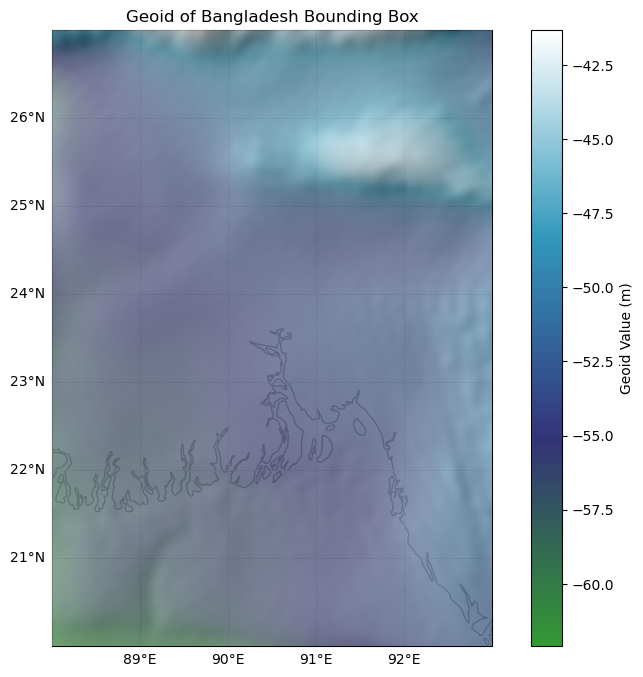

In [46]:

#geoid directory
geoid_path = '/home/sahar/output_tif/Bangladesh_bbox_Geoid_15s.tif'

#read geoid
with rasterio.open(geoid_path) as src:
    # Read the geoid data as a numpy array
    geoid_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(geoid_array, 330, 30)

#get the extent of the geoid
with rasterio.open(geoid_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot geoid
cax = ax.imshow(geoid_array, cmap='ocean', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Geoid Value (m)')
plt.title('Geoid of Bangladesh Bounding Box')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Digital Elevation Model and Bedrock Elevation


 All ETOPO tiles are in horizontal WGS84 geographic coordinates (EPSG:4326) and referenced in meters relative to the Earth Gravitational Model of 2008 (EGM2008) geoid surface (EPSG:3855). Each tile comes with an accompanying “geoid” tile for converting EGM2008 geoid heights into WGS84 ellipsoid elevation heights (EPSG:4979). 

**Elevation Conversion**
To convert a given tile from EGM2008 to WGS84-referenced elevations, add the values of the elevation tile to the geoid-height tile:

   **ETOPO Elevation (EGM2008) + GEOID = WGS84 Elevation**

https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/docs/1.2%20ETOPO%202022%20User%20Guide.pdf, 7/8/2023

Therefore, to compute the elevation model, the bedrock elevation needs to be added to the Geoid. Bedrock elevation of the study area is obtained from the ETOPO 2022 Bedrock model with 15 arcsecond resolution and is Extracted from the Grid Extractor function for Bangladesh bbox as Geotiff files. https://www.ncei.noaa.gov/maps/grid-extract/ 7/1/2023


## Bedrock Elevation

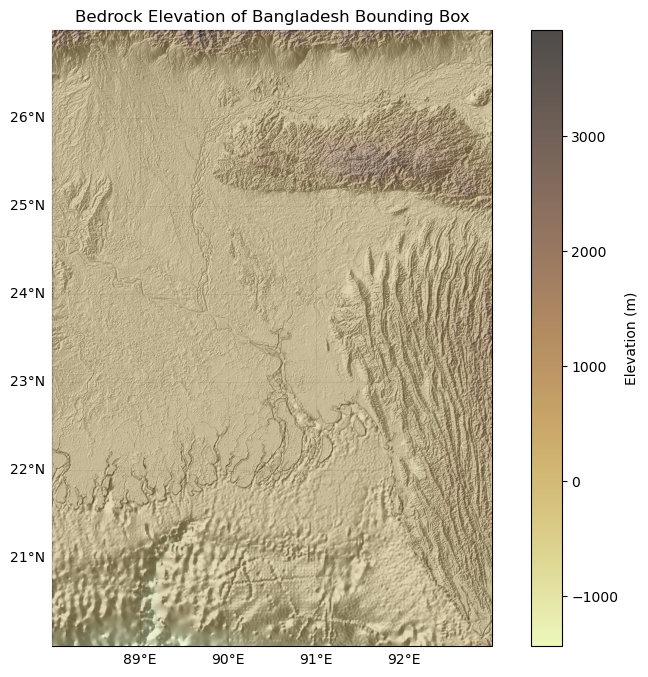

In [38]:
#bedrock directory
bedrock_path = '/home/sahar/output_tif/Bangladesh_Bedrock_15arcsec.tiff'

#read bedrock
with rasterio.open(bedrock_path) as src:
    # Read the bedrock data as a numpy array
    bedrock_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(bedrock_array, 330, 30)

#get the extent of the bedrock
with rasterio.open(bedrock_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot bedrock
cax = ax.imshow(bedrock_array, cmap=cmocean.cm.turbid, extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Elevation (m)')
plt.title('Bedrock Elevation of Bangladesh Bounding Box')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

In order to Calculate the DEM, having Geoid and Bedrock Elevation, in QGIS software these two geotif files are added together using Rasteri Calculator. The requirement of the calulation is that input layers be in the same coordinate Reference Systems. In the next block the coordinates of Geoid, Bedrock and IPCC are checked........RESAMPLe ro khodesh anjam mide? exten chi mishe.............
..................
...............
.................
...............

## Digital Elevation Model

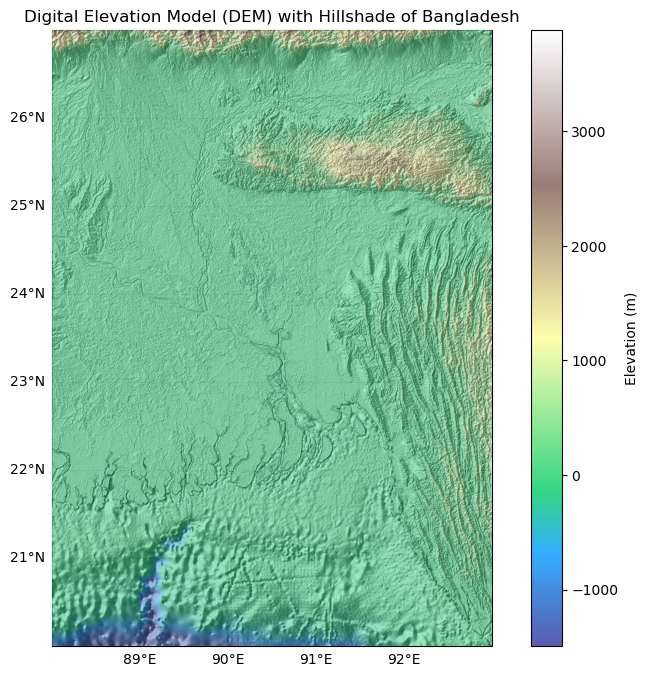

In [51]:
#DEM directory
dem_path = '/home/sahar/output_tif/Bangladesh_DEM.tif'

#read DEM
with rasterio.open(dem_path) as src:
    # Read the DEM data as a numpy array
    dem_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(dem_array, 330, 30)


#get the extent f the DEM
with rasterio.open(dem_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)

cmap = plt.cm.terrain
cmap.set_under('blue')  # Set color for values below the minimum elevation

#plot DEM
cax = ax.imshow(dem_array, cmap= cmap, extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)#GMT colormaps instead could be used
plt.colorbar(cax, label='Elevation (m)')
plt.title('Digital Elevation Model (DEM) with Hillshade of Bangladesh')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# cheking the CRS of the inputs 

In [13]:

#Bedrock
with rasterio.open('/home/sahar/output_tif/Bangladesh_Bedrock_15arcsec.tiff') as src:
    #read the image data
    image = src.read(1)
    #get transform and bounds of the image
    transform = src.transform
    bounds = src.bounds
    #get crs
    crs = src.crs
    print("CRS of DEM:", crs)

#Geoid
with rasterio.open('/home/sahar/output_tif/Bangladesh_bbox_Geoid_15s.tif') as src:
    #read the image data
    image = src.read(1)
    #get transform and bounds of the image
    transform = src.transform
    bounds = src.bounds
    #get crs
    crs = src.crs
    print("CRS of Geoid:", crs)
#IPCC SLC
with rasterio.open('/home/sahar/output_tif/Bangladesh_alt_sea_level_change_alt_nearest2020_ds_median_ssp585.tif') as src:
    #read the image data
    image = src.read(1)
    #get transform and bounds of the image
    transform = src.transform
    bounds = src.bounds
    #get crs
    crs = src.crs
    print("CRS of IPCC SL:", crs)


CRS of DEM: EPSG:4326
CRS of Geoid: EPSG:4326
CRS of IPCC SL: EPSG:4326


# Sea Level for the intended epochs
In order to have the sea level at year 2020 and 2100, the interpolated masked IPCC projections maps which is sea level change of those years are added to the current Mean Sea Level. This process has been done using Raster calculator in QGIS, for example for scenario-ssp119 of the year 2020:

Bangladesh_GeoidplusIPCC_2020_ssp119.tif= "Bangladesh_bbox_Geoid_15s@1" + "Bangladesh_alt_sea_level_change_alt_nearest2020_ds_median_ssp119@1"

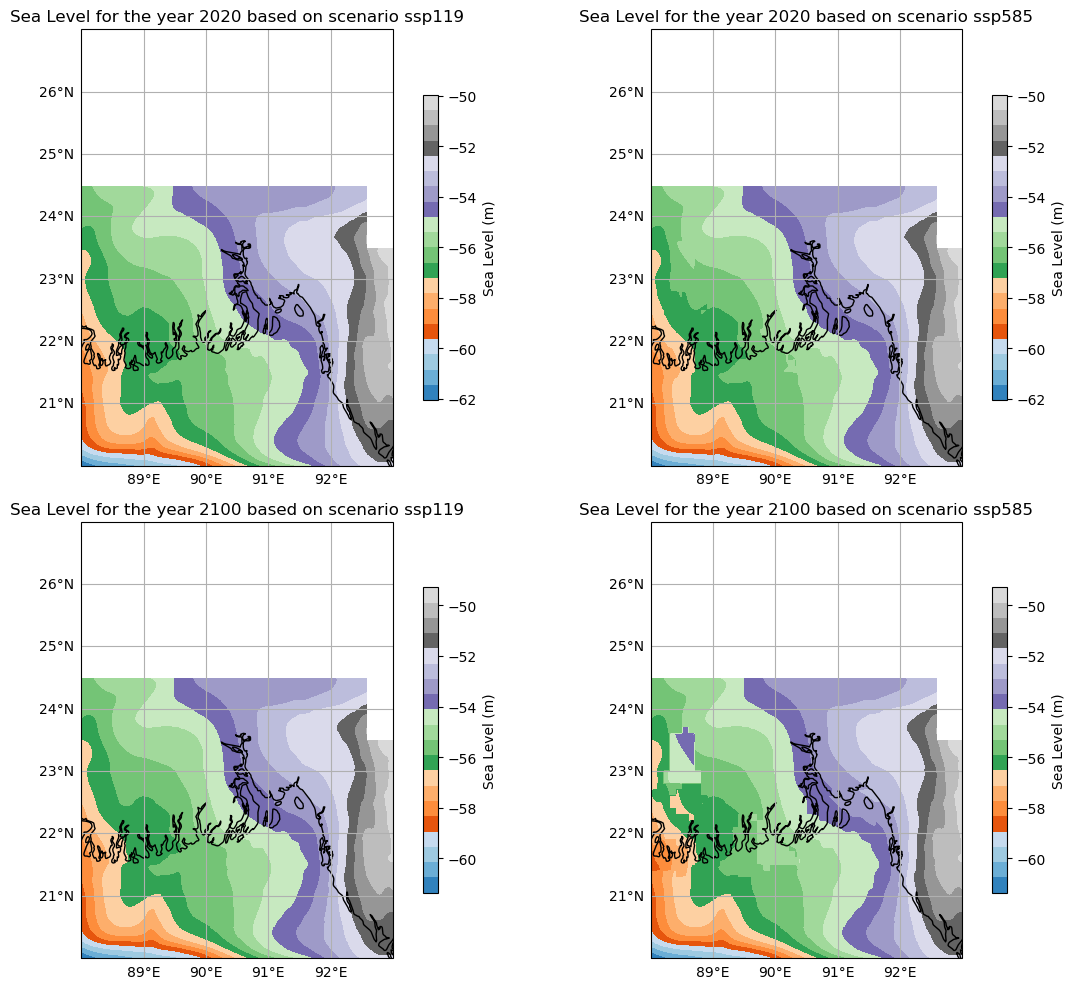

In [61]:
#import the list of the rasters of Geoid+IPCC sea level change
raster_paths = [
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2020_ssp119.tif',
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2020_ssp585.tif',
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2100_ssp119.tif',
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2100_ssp585.tif'
]
#list for interation
scenario_names = ['ssp119', 'ssp585', 'ssp119', 'ssp585']
year_names = ['2020', '2020', '2100', '2100']
#plot the rasters in a loop
fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

for i, raster_path in enumerate(raster_paths):
    dataset = gdal.Open(raster_path)
    band = dataset.GetRasterBand(1)
    SL_array = band.ReadAsArray()

    transform = dataset.GetGeoTransform()
    x_res = transform[1]
    y_res = transform[5]
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    xmin, ymin, xmax, ymax = bbox
    x_vals = np.arange(xmin, xmax, x_res)
    y_vals = np.arange(ymin, ymax, y_res)

    ax = axs[i // 2, i % 2]
    im = ax.imshow(SL_array, extent=[xmin, xmax, ymin, ymax], cmap='tab20c')
    gl = ax.gridlines(draw_labels=True)

    gl.right_labels = False

    gl.top_labels = False
    ax.set_title(f'Sea Level for the year {year_names[i]} based on scenario {scenario_names[i]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label('Sea Level (m)')

    ax.coastlines()

plt.tight_layout()
plt.show()


# Visualizing Sea Level and DEM with same colors and ranges  in order to be comparable

/tmp/ipykernel_8656/3159012861.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 17)


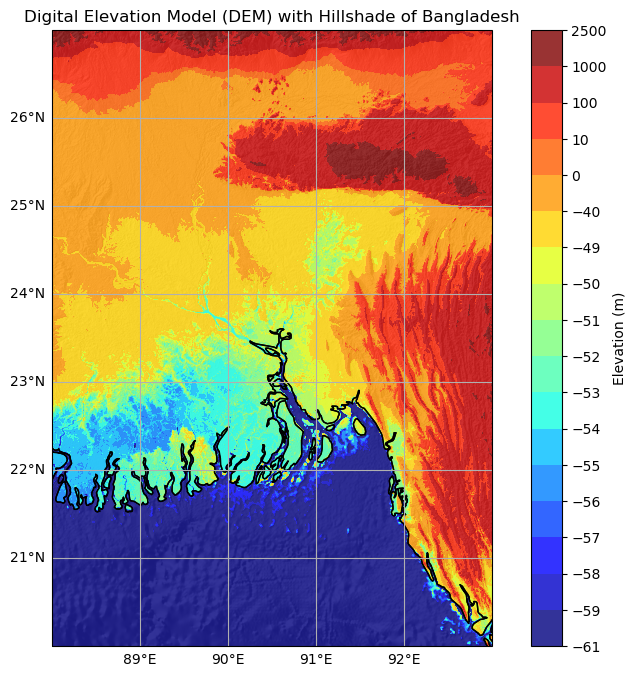

In [72]:
import matplotlib.cm as cm

#dem directory
dem_path = '/home/sahar/output_tif/Bangladesh_DEM.tif'

#readDEM
with rasterio.open(dem_path) as src:
    # Read the DEM data as a numpy array
    dem_array = src.read(1)

# Hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

# Compute the hillshade
hillshade_array = hillshade(dem_array, 330, 30)

# Get the extent of the DEM
with rasterio.open(dem_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

cmap = cm.get_cmap('jet', 17)
cranges = [-61, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -40, 0, 10, 100, 1000, 2500]
norm = colors.BoundaryNorm(cranges, cmap.N)

# Plot the figure
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)

# Plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5)

# plot DEM with custom colormap
cax = ax.imshow(dem_array, cmap=cmap, extent=[xmin, xmax, ymin, ymax], alpha=0.8, norm=norm)
plt.colorbar(cax, label='Elevation (m)', ticks=cranges)

plt.title('Digital Elevation Model (DEM) with Hillshade of Bangladesh')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

plt.show()


/tmp/ipykernel_8656/3207517896.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 12)


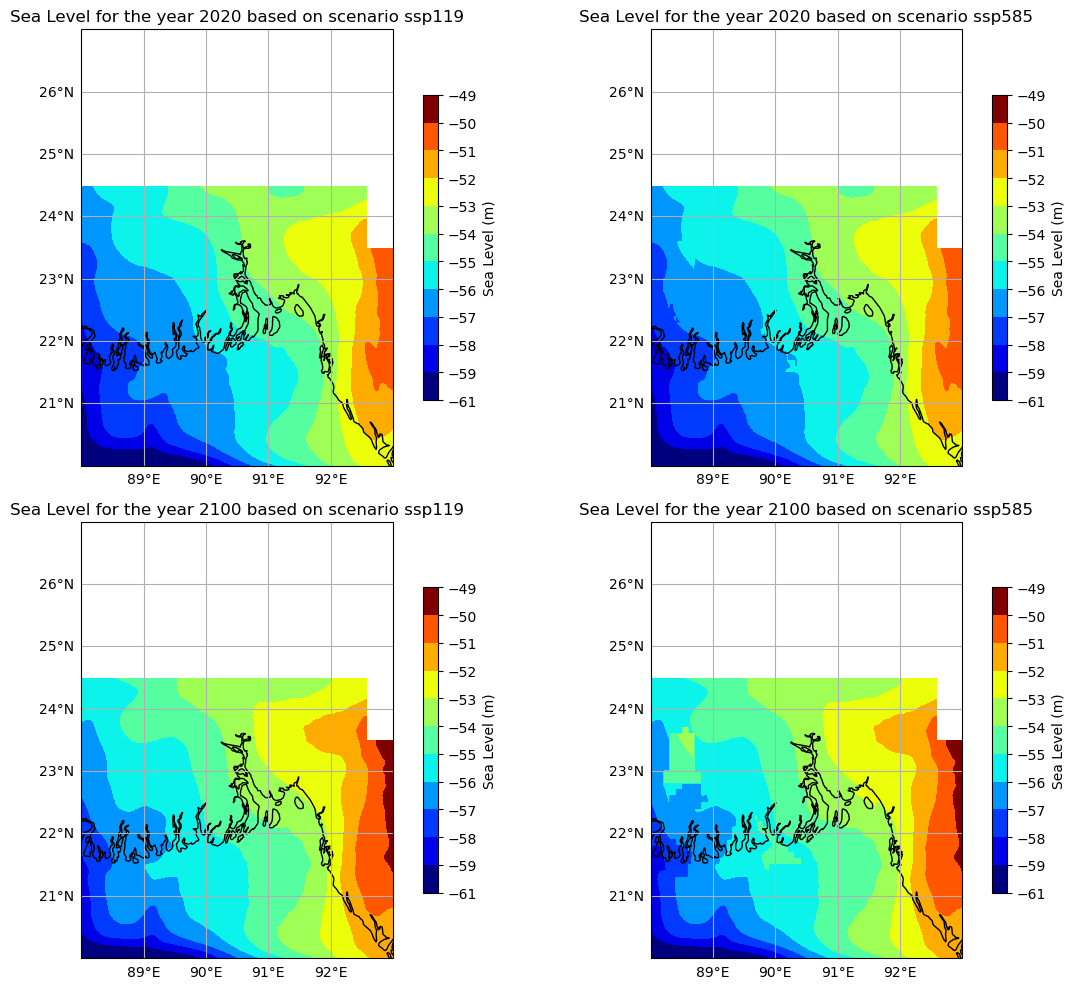

In [71]:
#import the list of the rasters of Geoid+IPCC sea level change
raster_paths = [
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2020_ssp119.tif',
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2020_ssp585.tif',
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2100_ssp119.tif',
    '/home/sahar/output_tif/Bangladesh_GeoidplusIPCC_2100_ssp585.tif'
]
#list for interation
scenario_names = ['ssp119', 'ssp585', 'ssp119', 'ssp585']
year_names = ['2020', '2020', '2100', '2100']
#plot the rasters in a loop
fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

for i, raster_path in enumerate(raster_paths):
    dataset = gdal.Open(raster_path)
    band = dataset.GetRasterBand(1)
    SL_array = band.ReadAsArray()

    transform = dataset.GetGeoTransform()
    x_res = transform[1]
    y_res = transform[5]
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    xmin, ymin, xmax, ymax = bbox
    x_vals = np.arange(xmin, xmax, x_res)
    y_vals = np.arange(ymin, ymax, y_res)
# Define the custom colormap and corresponding elevation levels
    cmap = cm.get_cmap('jet', 12)
    cranges = [-61, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49]
    norm = colors.BoundaryNorm(cranges, cmap.N)


    ax = axs[i // 2, i % 2]
    im = ax.imshow(SL_array, cmap=cmap, extent=[xmin, xmax, ymin, ymax], norm=norm)
    gl = ax.gridlines(draw_labels=True)

    gl.right_labels = False

    gl.top_labels = False
    ax.set_title(f'Sea Level for the year {year_names[i]} based on scenario {scenario_names[i]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cbar = plt.colorbar(im, ax=ax, shrink=0.7, ticks=cranges)
    cbar.set_label('Sea Level (m)')

    ax.coastlines()

plt.tight_layout()
plt.show()


# Creating Flood Maps
Having the sea level for the perspective years, and the topography of the study area, we are able to identify the flooded area. This process has been done in QGIS with raster calculator, in such a way that all areas whose elevation is lower than the sea level is flooded. for example for scenario-ssp119 of the year 2020:

"Bangladesh_Bedrock_15arcsec@1" <= "Bangladesh_GeoidplusIPCC_2020_ssp119@1"

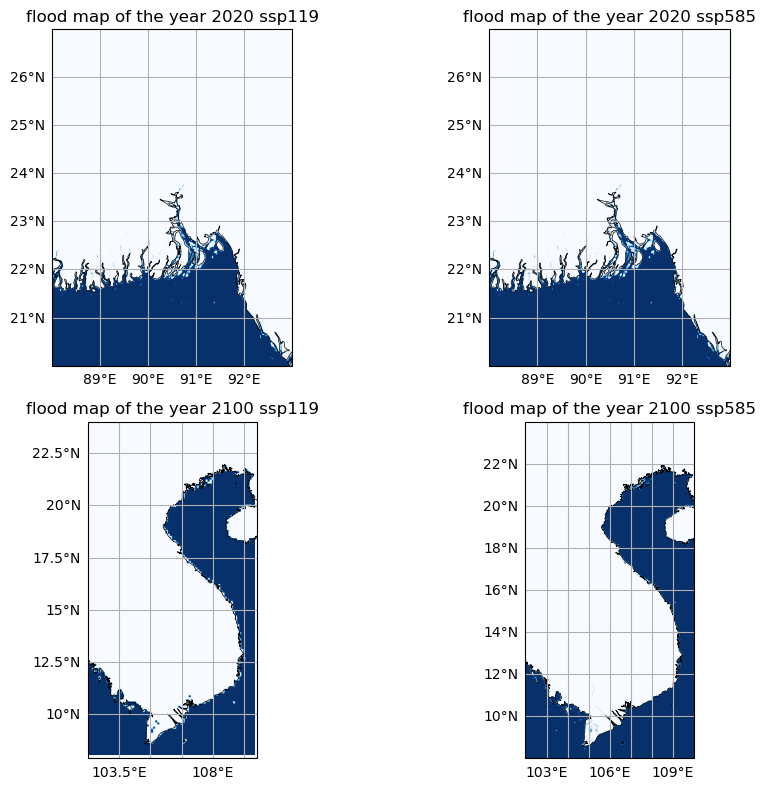

In [15]:
#importing and plotting the flood map created in QGIS
raster_files = {
    'flood map of the year 2020 ssp119': '/home/sahar/output_tif/Bangladesh_flood_2020_ssp119.tif',
    'flood map of the year 2020 ssp585': '/home/sahar/output_tif/Bangladesh_flood_2020_ssp585.tif',
    'flood map of the year 2100 ssp119': '/home/sahar/output_tif/Bangladesh_flood_2100_ssp119.tif',
    'flood map of the year 2100 ssp585': '/home/sahar/output_tif/Bangladesh_flood_2100_ssp585.tif',
}

crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': crs})

for ax, (title, file_path) in zip(axs.flat, raster_files.items()):
    with rasterio.open(file_path) as src:
        flood_map = src.read(1)
        transform = src.transform
        bounds = src.bounds

    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    im = ax.imshow(flood_map, extent=extent, cmap='Blues', vmin=0, vmax=1, origin='upper', transform=crs)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)

    gl = ax.gridlines(draw_labels=True)

    gl.right_labels = False

    gl.top_labels = False
    ax.coastlines(resolution='10m', color='black', linewidth=0.5)

plt.tight_layout()
plt.show()
